<a href="https://colab.research.google.com/github/AbeRodz/computer-vision-II/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP Vision por computadora II

## Integrantes

- Abraham Rodriguez
- Cecilia Sanchez

In [2]:
!nvidia-smi

Sun Aug 20 13:32:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8               7W / 285W |   1013MiB / 12282MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import torch
import torchvision
import torchsummary
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import pandas as pd
#import torchmetrics
#from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

c:\Users\Usuario\Documents\uba_abraham\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

Utility functions for plotting, and loading images

In [4]:
def plot_predicted_image(original, mask, predicted_mask):

    _, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(original.transpose(1,2,0))
    ax[0].set_title("Original")

    ax[1].imshow(mask.transpose(1,2,0))
    ax[1].set_title("original mask")
    
    ax[2].imshow(predicted_mask.transpose(1,2,0))
    ax[2].set_title("predicted mask")

    plt.show()

In [5]:
def load_dataset_paths(path: str):
    train_data_dir = f"{path}/dataset/training/image_2/"
    train_gt_dir = f"{path}/dataset/training/gt_image_2/"

    test_data_dir = f"{path}/dataset/testing/"
    return train_data_dir, train_gt_dir, test_data_dir

In [6]:
def show_image_list(images : list, nrows = 1, figsize = (12,8), cmap :list = ['gray'], titles = [""]):
    ncols = len(images)
    _, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)

    axes = axes.ravel()

    for i in range(len(axes)):
       axes[i].set_axis_off()
       if (cmap is None):
           axes[i].imshow(images[i])
           if (len(titles)>0):
               axes[i].set_title(titles[i])
       elif (len(cmap)>1):
           axes[i].imshow(images[i], cmap=cmap[i])
           if (len(titles)>0):
               axes[i].set_title(titles[i])

       else:
           axes[i].imshow(images[i], cmap=cmap[0])
           if (len(titles)>0):
               axes[i].set_title(titles[i])

In [7]:
def open_images_cv(path, masked = False):
  """
  open images concurrently by using a thread pool
  """
  temp = []
  def read_image(image):
    return cv.resize(cv.cvtColor(cv.imread(os.path.join(path,image)), cv.COLOR_BGR2RGB),(128,128))


  images = os.listdir(path)
  images=sorted(images)
  if masked==True:
    images = [entry for entry in images if "road" in entry]

  with ThreadPoolExecutor() as executor:
    files = executor.map(read_image,images)
    for f in files:
      temp.append(np.asarray(f))
  return np.array(temp)

La siguiente linea es un optimizador de cudnn

In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')
#cd /content/drive/MyDrive/dataset/vision/kitti

In [10]:
train_data_dir, train_gt_dir, test_data_dir = load_dataset_paths('.')

In [11]:
data=open_images_cv(train_data_dir,masked=False)
masks=open_images_cv(train_gt_dir,masked=True)

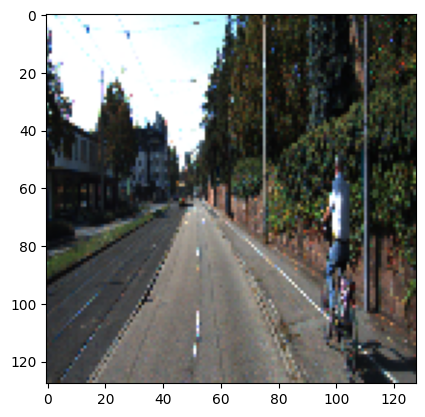

In [12]:
plt.imshow(data[0])

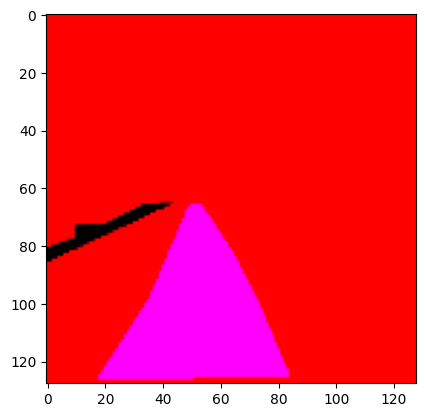

In [13]:
plt.imshow(masks[0])

# Binarizing masks

In [14]:
def binarize(mask: np.ndarray):
    """
    Binarizes the mask image, and transforms it onto grayscale
    """
    road_label =np.array([255, 0, 255])
    cond=np.all(mask == road_label, axis = 2)
    mask=mask * cond[..., np.newaxis]
    mask = cv.cvtColor(mask[..., :3],cv.COLOR_RGB2GRAY)
    return mask

In [15]:
def convert_to_binary_mask(masks: np.ndarray) -> np.ndarray:
    temp = []
    mask_length=len(masks)
    for i in range(mask_length):

        temp.append(binarize(masks[i]))
    binary_masks = np.array(temp)
    binary_masks=np.expand_dims(binary_masks, axis=-1)
    return binary_masks

In [16]:
binary_mask = convert_to_binary_mask(masks)
binary_mask.shape

(289, 128, 128, 1)

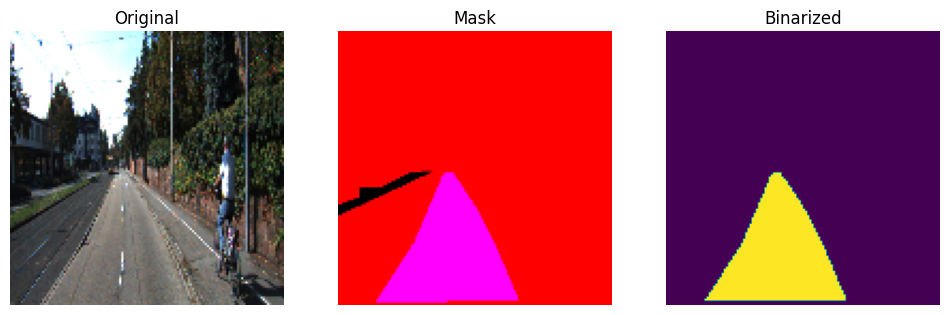

In [17]:
show_image_list([data[0], masks[0], binary_mask[0]],cmap=None,titles=["Original", "Mask","Binarized"])

In [18]:
binary_mask[binary_mask != 0.0]=1.0

In [19]:
data  = data / 255.0

## Data Augmentation

In [79]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(10,-10), p=0.5,border_mode=cv.BORDER_CONSTANT),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
    A.RandomShadow(shadow_dimension=20),
    A.RandomSunFlare(src_radius=50)
])

In [21]:
data=data.astype(np.float32)
binary_mask=binary_mask.astype(np.float32)

In [94]:
test_aug=augmentation_pipeline(image=data[5], mask=binary_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

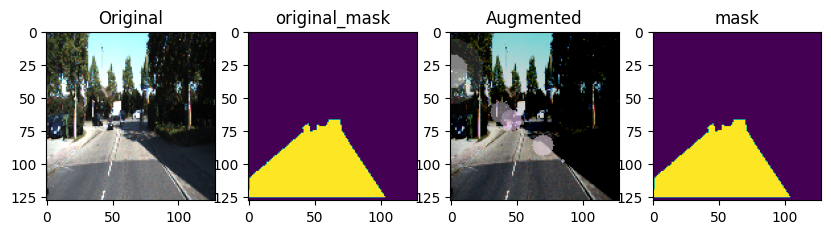

In [95]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(binary_mask[5])
ax[1].set_title("original_mask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()

In [96]:
num_augmented=3
for i in range(len(data)):
    for j in range(num_augmented):
      image = data[i]
      mask = binary_mask[i]

      augmented = augmentation_pipeline(image=image, mask=mask)

      image_augmented = augmented["image"]
      mask_augmented = augmented["mask"]
      data = np.vstack((data, image_augmented[np.newaxis,...]))
      binary_mask = np.vstack((binary_mask, mask_augmented[np.newaxis,...]))

In [97]:
type(data.dtype)

numpy.dtype[float32]

In [98]:
data.shape

(1156, 128, 128, 3)

In [99]:
binary_mask.shape

(1156, 128, 128, 1)

In [100]:
def test_train_validation_split(data : np.ndarray, true_masks: np.ndarray,train_size = 0.8):
    """
    Splits dataset onto train, test, and validation datasets
    """
    train_set_size = int(len(data) * train_size)
    validation_set_size = int(len(data) * 0.1)
    test_set_size = len(data) - train_set_size - validation_set_size
    
    X_test=data[:test_set_size].transpose((0, 3, 1, 2))
    y_test=true_masks[:test_set_size].transpose((0, 3, 1, 2))


    data=data[test_set_size:]
    true_masks=true_masks[test_set_size:]

    # shuffle
    shuffled_indices = np.random.permutation(len(data))
    shuffled_data = data[shuffled_indices]
    shuffled_masks = true_masks[shuffled_indices]

    X_train=shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
    y_train=shuffled_masks[:train_set_size].transpose((0, 3, 1, 2))

    X_val=shuffled_data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
    y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))


    return X_train, y_train, X_test, y_test , X_val, y_val 

In [101]:
X_train, y_train, X_test, y_test , X_val, y_val  = test_train_validation_split(data,binary_mask)

In [102]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, images,masks):
        self.images=images
        self.masks=masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image= self.images[index]
        mask=self.masks[index]
        return image,mask

Dataloaders Asincronos

In [103]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=64,shuffle=False)

print(f"Train dataloader length: {len(train_dataloader)} batches of size {64}")
print(f"Validation dataloader length: {len(val_dataloader)} batches of size {64}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {64}")

Train dataloader length: 15 batches of size 64
Validation dataloader length: 2 batches of size 64
Test dataloader length: 2 batches of size 64


# Creando U-NET

## U-Net

In [104]:
import torchvision.transforms.functional as TF

In [131]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() #
        #bias is set to false because we apply batch normalization
        self.dconv=torch.nn.Sequential(torch.nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
                                 torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dconv(x)

class UNET(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()

        self.ups = torch.nn.ModuleList()
        self.downs = torch.nn.ModuleList()

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # UP
        for feature in reversed(features):
            self.ups.append(torch.nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) 
            self.ups.append(DoubleConv(feature*2, feature))


        self.left_over = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = torch.nn.Conv2d(features[0], out_channels, kernel_size=1) 

    def forward(self,x):
        skip_connections = []

        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)
            x=self.pool(x)

        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2):

            sc=skip_connections[idx//2]
            x=self.ups[idx](x) 

            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) 
            x = self.ups[idx+1](concat_skip) 


        return torch.sigmoid(self.final_conv(x))#last step in forward

## Instanciando U-Net

In [116]:
import torch.optim as optim

EPOCHS=80
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = smp.utils.losses.DiceLoss()
LEARNING_RATE=3e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Implementacion de EarlyStopping

In [117]:
import copy

class EarlyStopping():
  """
  EarlyStopping serves as a mechanism to check if the loss does not have a considerable change, this can help to prevent overfitting
  and reduce the number of epochs (training time)
  """
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [132]:
class Trainer():
  """
  Custom trainer Class that wraps the training and evaluation of a model, using torch autocast 
  """
  def __init__(self, model : torch.nn.Module, train_data_loader: DataLoader,test_data_loader: DataLoader ,loss_fn:torch.nn.Module, optimizer: torch.optim.Optimizer, device: str):
    self.model = model
    self.train_data_loader = train_data_loader
    self.test_data_loader = test_data_loader
    self.loss_fn = loss_fn
    self.metrics = None
    self.optimizer = optimizer
    self.device = device

  def train_model(self,use_amp = False):

    model = self.model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    losses = []
    bar = tqdm(self.train_data_loader)
    for train_input, train_mask in bar:
        train_mask = train_mask.to(self.device)
        train_input=train_input.to(self.device)
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            output = model(train_input)
            loss = loss_fn(output, train_mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # outputs=model(train_input.float())
        # loss = loss_fn(outputs.float(), train_mask.float())
        losses.append(loss.item())
        #loss.backward()
        #optimizer.step()
        #optimizer.zero_grad()
        for param in model.parameters():
          param.grad = None
        bar.set_description(f"loss {loss:.5f}")
    return np.mean(losses)

  def eval_model(self):
    model = self.model.eval()

    losses = []
    bar = tqdm(self.test_data_loader)
    with torch.no_grad():
        for val_input, val_mask in bar:

            val_mask = val_mask.to(self.device)
            val_input=val_input.to(self.device)
            outputs=model(val_input.float())

            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())
            bar.set_description(f"val_loss {loss:.5f}")

    return np.mean(losses)

## Training

In [109]:
from collections import defaultdict
history = defaultdict(list)

In [133]:
torch.compile(model) # works on colab

RuntimeError: Windows not yet supported for torch.compile

In [134]:
train = Trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer, DEVICE)

In [111]:
from segmentation_models_pytorch import utils

In [93]:
loss=np.inf

es = EarlyStopping(patience = 5)
done = False
for epoch in range(EPOCHS) :

    train_loss = train.train_model(True)
    print(epoch)
    val_loss = train.eval_model()
    if es(model,val_loss):
      done = True
      print(f'Patience ran out : {es.status}')
      break
    print(f'EStop:[{es.status}]')
    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 50)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}\n')   

    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state_unet.bin')
        loss = val_loss


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

NameError: name 'train' is not defined

In [118]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
   utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/unet-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [119]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [120]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    es = EarlyStopping(patience = 5)
    done = False
    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        if es(model,valid_logs['dice_loss']):
            done = True
            print(f'Patience ran out : {es.status}')
            break
        print(f'EStop:[{es.status}]')
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s, dice_loss - 0.6825, iou_score - 0.1899]
EStop:[0/5]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s, dice_loss - 0.4636, iou_score - 0.3968]
EStop:[0/5]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00, 11.05it/s, dice_loss - 0.2272, iou_score - 0.6611]
EStop:[0/5]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s, dice_loss - 0.1826, iou_score - 0.7088]
EStop:[0/5]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s, dice_loss - 0.1741, iou_score - 0.7133]
EStop:[0/5]
Model saved!

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00, 11.63it/s, dice_loss - 0.2425, iou_score - 0.6216]
EStop:[1/5]

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00, 10.85it/s, dice_loss - 0.1409, iou_score - 0.7591]
EStop:[0/5]
Model saved!

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00, 11.56it/s, dice_loss - 0.168, iou_score - 0.7179]
EStop:[1/5]

Ep

In [122]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
dice_loss,0.535581,0.312376,0.209486,0.170844,0.163813,0.149121,0.137052,0.142425,0.130350,0.119344,...,0.063138,0.057726,0.054304,0.051977,0.050376,0.050928,0.047515,0.047419,0.046955,0.049567
iou_score,0.376076,0.619928,0.697163,0.726613,0.729114,0.747948,0.765354,0.755605,0.774248,0.791165,...,0.882578,0.892082,0.898145,0.902190,0.905030,0.904031,0.910166,0.910300,0.911184,0.906345


In [123]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count = count_parameters(model)
count

31037633

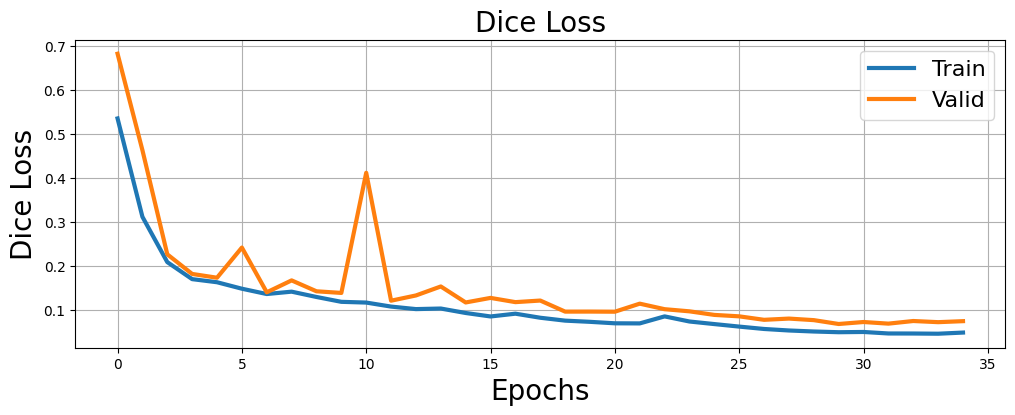

In [124]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss, lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

# Predictions

In [125]:
prediction=model(torch.tensor(X_test[56][np.newaxis,...],device=DEVICE)).cpu().detach().numpy()

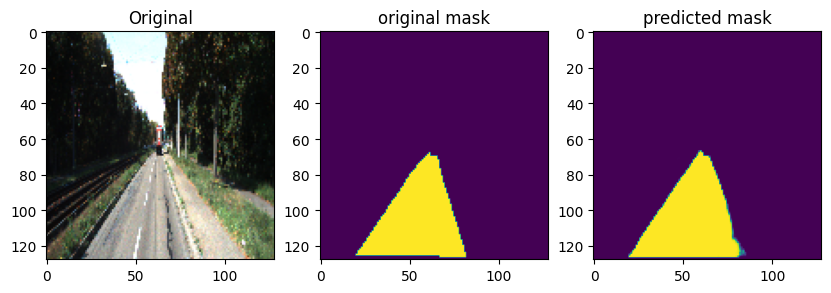

In [126]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(prediction[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

In [128]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [129]:
loss,masks=get_predicted_masks(model,test_dataloader,loss_fn,DEVICE)
print(loss)

0.045721232891082764


In [50]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

# Testing

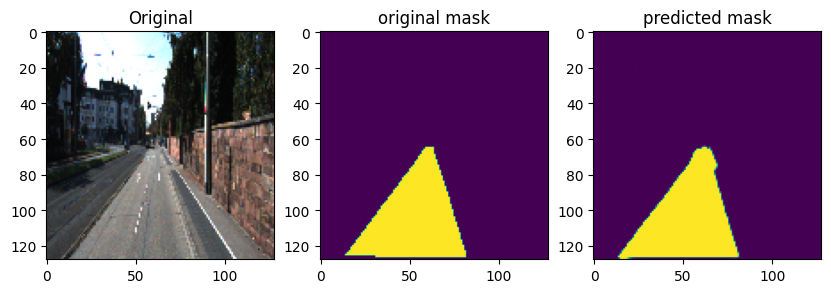

In [51]:
plot_predicted_image(X_test[2],y_test[2],predicted_masks[2])

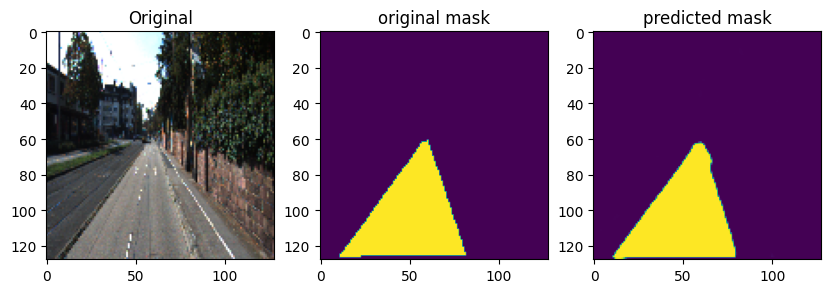

In [52]:
plot_predicted_image(X_test[1],y_test[1],predicted_masks[1])

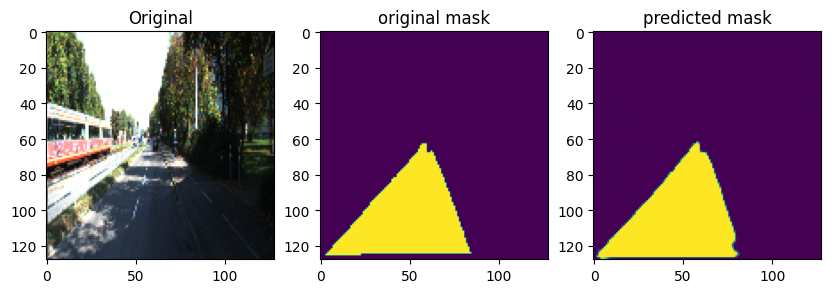

In [53]:
plot_predicted_image(X_test[14],y_test[14],predicted_masks[14])

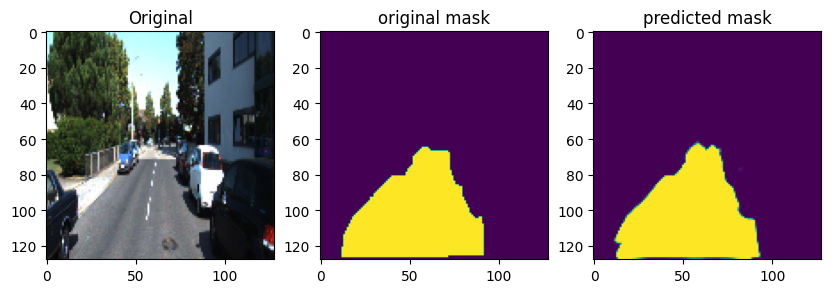

In [54]:
plot_predicted_image(X_test[4],y_test[4],predicted_masks[4])

# Deeplab

In [111]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [63]:
from segmentation_models_pytorch import utils

In [112]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
   utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [113]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [114]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    es = EarlyStopping(patience = 5)
    done = False
    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        if es(model,valid_logs['dice_loss']):
            done = True
            print(f'Patience ran out : {es.status}')
            break
        print(f'EStop:[{es.status}]')
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00, 25.32it/s, dice_loss - 0.4641, iou_score - 0.3661]
EStop:[0/5]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00, 25.64it/s, dice_loss - 0.322, iou_score - 0.5337]
EStop:[0/5]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00, 25.00it/s, dice_loss - 0.1598, iou_score - 0.7335]
EStop:[0/5]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00, 25.32it/s, dice_loss - 0.1162, iou_score - 0.8014]
EStop:[0/5]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00, 25.97it/s, dice_loss - 0.0941, iou_score - 0.8328]
EStop:[0/5]
Model saved!

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00, 25.32it/s, dice_loss - 0.1, iou_score - 0.8229]
EStop:[1/5]

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00, 25.64it/s, dice_loss - 0.09398, iou_score - 0.8339]
EStop:[0/5]
Model saved!

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00, 25.97it/s, dice_loss - 0.09704, iou_score - 0.8269]
EStop:[1/5]

Epo

In [115]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
dice_loss,0.382639,0.160847,0.104297,0.086630,0.074123,0.068680,0.063218,0.059127,0.055215,0.053503,...,0.031032,0.029899,0.029175,0.028470,0.028008,0.029089,0.029633,0.027882,0.026740,0.025653
iou_score,0.540308,0.759070,0.824782,0.849228,0.868219,0.876855,0.885684,0.892693,0.899385,0.902040,...,0.942004,0.944021,0.945363,0.946579,0.947345,0.945344,0.944240,0.947560,0.949691,0.951807


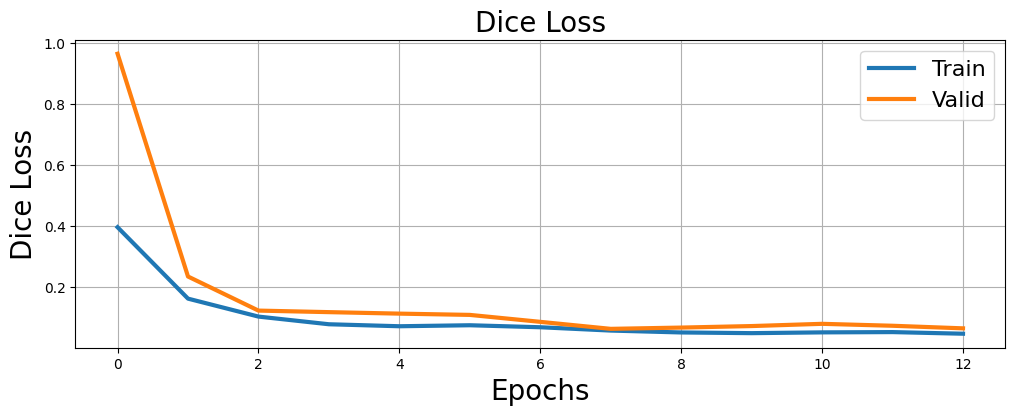

In [110]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss, lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [116]:
loss,masks=get_predicted_masks(model,test_dataloader,loss,DEVICE)
print(loss)

0.03287315368652344


In [117]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

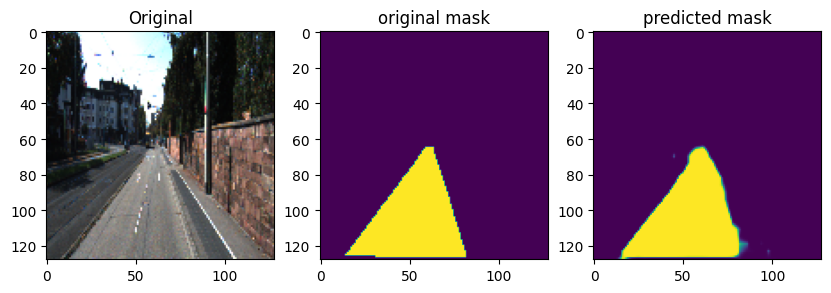

In [118]:
plot_predicted_image(X_test[2],y_test[2],predicted_masks[2])

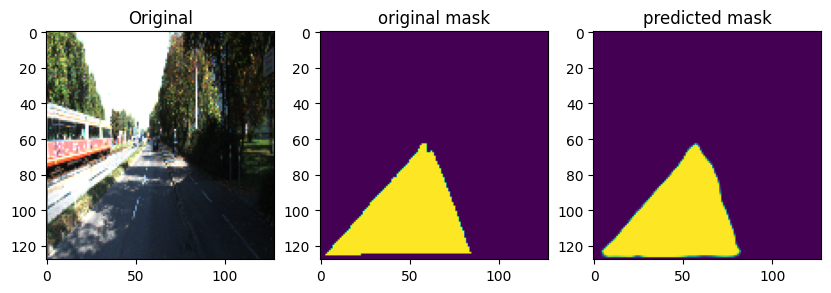

In [119]:
plot_predicted_image(X_test[14],y_test[14],predicted_masks[14])

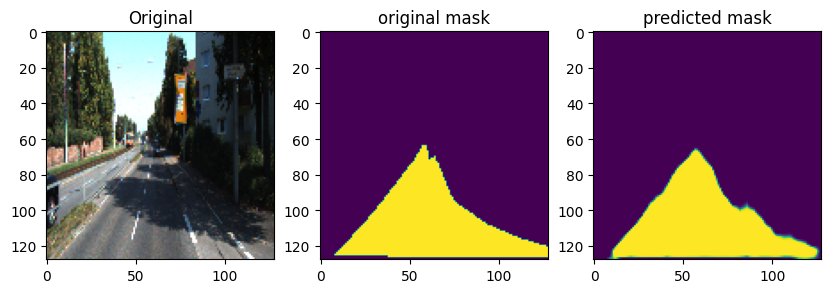

In [120]:
plot_predicted_image(X_test[12],y_test[12],predicted_masks[12])

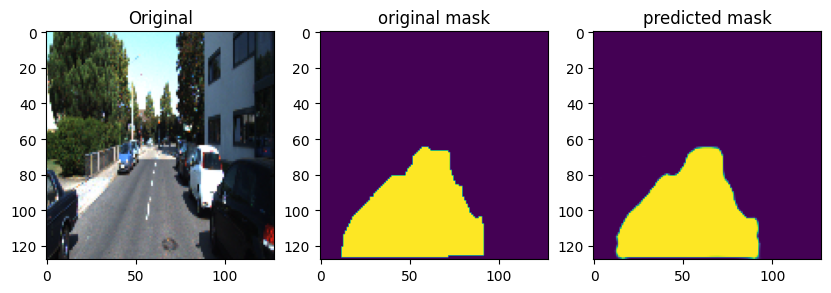

In [121]:
plot_predicted_image(X_test[4],y_test[4],predicted_masks[4])

In [77]:
count = count_parameters(model)
count

45669713

# U-NET++

In [76]:
ENCODER = 'xception'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [77]:
LEARNING_RATE = 1e-3

In [78]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 80

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
   utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unetplus-imagenet-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/unetplus-imagenet-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [60]:
model.name

'unetplusplus-xception'

In [79]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [80]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    es = EarlyStopping(patience = 5)
    done = False
    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        if es(model,valid_logs['dice_loss']):
            done = True
            print(f'Patience ran out : {es.status}')
            break
        print(f'EStop:[{es.status}]')
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s, dice_loss - 0.4334, iou_score - 0.4513]
EStop:[0/5]
Model saved!

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00, 13.99it/s, dice_loss - 0.2346, iou_score - 0.7941]
EStop:[0/5]
Model saved!

Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, dice_loss - 0.1412, iou_score - 0.886]
EStop:[0/5]
Model saved!

Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00, 14.39it/s, dice_loss - 0.09553, iou_score - 0.8981]
EStop:[0/5]
Model saved!

Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00, 14.08it/s, dice_loss - 0.07771, iou_score - 0.8976]
EStop:[0/5]

Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00, 14.49it/s, dice_loss - 0.06571, iou_score - 0.9061]
EStop:[0/5]
Model saved!

Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00, 12.74it/s, dice_loss - 0.05684, iou_score - 0.9154]
EStop:[0/5]
Model saved!

Epoch: 7
valid: 100%|██████████| 2/2 [00:00<00:00, 14.29it/s, dice_loss - 0.0513, iou_score - 0.9197]
EStop:[0/5]

In [81]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
dice_loss,0.466319,0.260911,0.151963,0.096996,0.070339,0.057233,0.049245,0.043433,0.040396,0.039426,...,0.011296,0.010209,0.011228,0.012134,0.010407,0.009661,0.008793,0.008191,0.008142,0.008109
iou_score,0.565549,0.813786,0.871936,0.893975,0.911785,0.921904,0.929822,0.936706,0.938810,0.938238,...,0.980148,0.982289,0.980145,0.978171,0.981665,0.983122,0.984795,0.985914,0.985939,0.985936


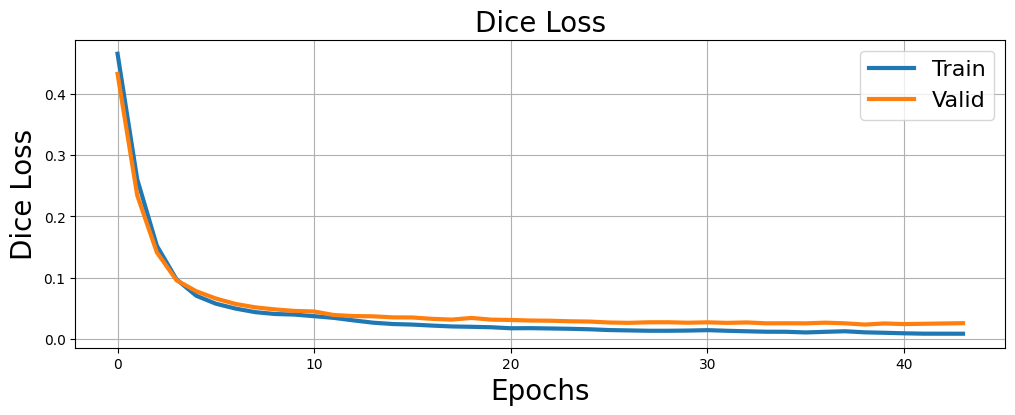

In [82]:
plt.figure(figsize=(12,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss, lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss, lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [83]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [106]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [84]:
loss,masks=get_predicted_masks(model,test_dataloader,loss,DEVICE)
print(loss)

0.016404002904891968


In [85]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

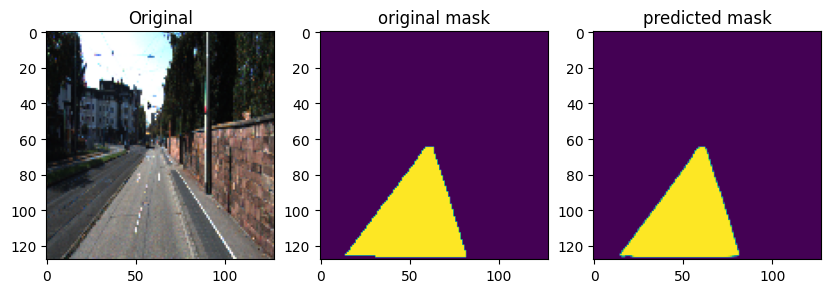

In [86]:
plot_predicted_image(X_test[2],y_test[2],predicted_masks[2])

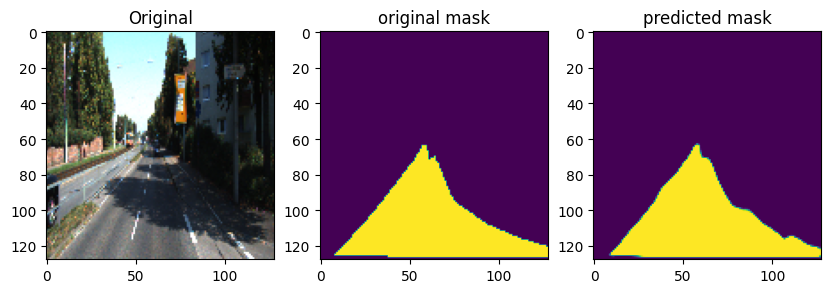

In [87]:
plot_predicted_image(X_test[12],y_test[12],predicted_masks[12])

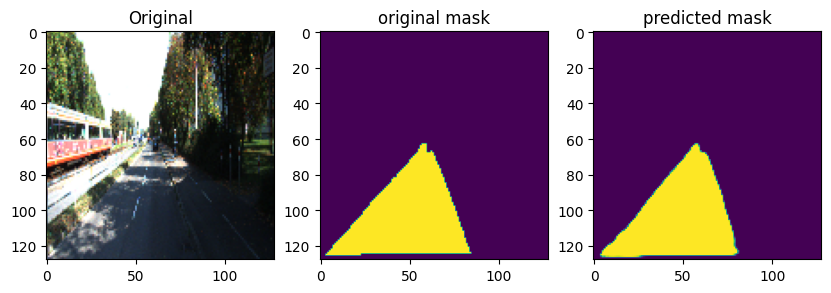

In [88]:
plot_predicted_image(X_test[14],y_test[14],predicted_masks[14])

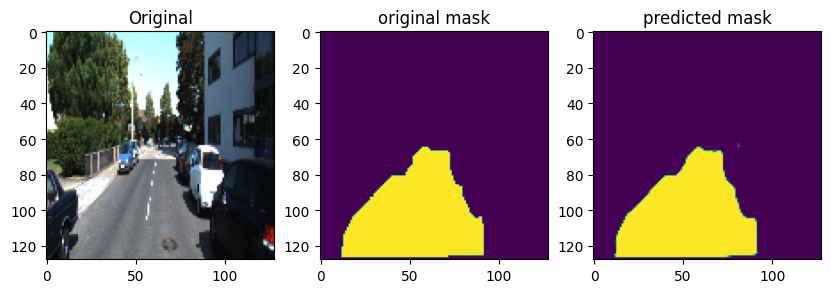

In [89]:
plot_predicted_image(X_test[4],y_test[4],predicted_masks[4])

In [130]:
count = count_parameters(model)
count

31037633

# Probando con videos

In [73]:
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv.addWeighted(initial_img, α, img, β, γ)

In [90]:
def save_to_video(model, video_path, output_name):
    
    vs = cv.VideoCapture(video_path)
    _, frame = vs.read()
    H, W, _ = frame.shape
    vs.release()
    #fourcc = cv.VideoWriter_fourcc(*'MP4V')
    fourcc = cv.VideoWriter_fourcc('M','J','P','G')
    out = cv.VideoWriter(f'{output_name}.avi', fourcc, 30, (W, H), True)
    cap = cv.VideoCapture(video_path)
    idx = 0
    while True:
        ret, frame = cap.read()
        if ret == False:
            cap.release()
            out.release()
            break
        H, W, _ = frame.shape
        
        ori_frame = frame

        frame = cv.resize(cv.cvtColor(frame,cv.COLOR_BGR2RGB),(128,128))

        frame = np.expand_dims(frame, axis=0)
        frame = frame / 255.0

        mask = model(torch.tensor(frame.transpose((0, 3, 1, 2)),device=DEVICE).float()).cpu().detach().numpy()
        #mask = mask > 0.5
        mask = mask.astype(np.float32)
        
        mask = cv.resize(mask[0].transpose(1,2,0), (W, H))
        mask = np.expand_dims(mask, axis=-1)
        zero_image = np.zeros_like(mask)
        mask = np.dstack((mask, zero_image, zero_image)) * 255
        mask = np.asarray(mask, np.uint8)
        combine_frame = weighted_img(mask, ori_frame)
        #cv.imwrite(f"video/{idx}_video.png", combine_frame)
        idx += 1

        out.write(combine_frame)

In [98]:
video_path = "./dataset/movie.mp4"
save_to_video(model,video_path,"output_movie")